<a href="https://colab.research.google.com/github/YuLu77/KPMG_Bike_Analysis/blob/main/A_B_testing_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Concersion analysis on Web Design**

#Import data and data cleaning


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [5]:
from google.colab import files
uploaded = files.upload()


Saving sample_ab_data.csv to sample_ab_data.csv


In [35]:
df = pd.read_csv('sample_ab_data.csv')
print(df.head(10))

   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          1
3   853541   28:03.1  treatment     new_page          1
4   864975   52:26.2    control     old_page          1
5   936923   20:49.1    control     old_page          0
6   679687   26:46.9  treatment     new_page          1
7   719014   48:29.5    control     old_page          0
8   817355   58:09.0  treatment     new_page          1
9   839785   11:06.6  treatment     new_page          1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
((df.group == 'treatment') & (df.landing_page == 'old_page')).sum()

np.int64(1965)

In [11]:
((df.group == 'control')&(df.landing_page== 'new_page')).sum()


np.int64(1928)

In [9]:
df['misaligned'] = ((df.group =='treatment') & (df.landing_page == 'old_page')) | ((df.group =='control')&(df.landing_page=='new_page'))
df = df[~df['misaligned']]
# ~ invert boolean conditions for filtering; df[...]Filters the DataFrame, keeping only rows where misaligned is False

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [13]:
df.user_id.nunique()

290584

In [14]:
df['user_id'].value_counts().sort_values(ascending=False).head()

,count
user_id,
822618,2
904418,2
879483,2
888039,2
737298,2


# make assumption

In [15]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,1
2893,773192,55:59.6,treatment,new_page,0


if a user appears multiple times, we assume their lastest interaction reflects their final decision, so we keep the row with most recent timestamp.

In [16]:
df.drop(1899,axis=0,inplace=True)

In [17]:
df[['user_id','group']].groupby('group').count()

,user_id
group,
control,147202
treatment,147275


In [18]:
df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'mean'})
#conversion rate in each group

,user_id,converted
group,,
control,147202,0.120467
treatment,147275,0.125378


# Analyze results
let's assume that new page does not have higher conversion rate than the old page at 5% Type I eorre. so the hypothesis would be:
Null: P new- P old <= 0
Alternative: P new - P old > 0

In [21]:
convert_old = df[df.group == 'control'].converted.sum() #total number of conversion from control group
convert_new = df[df.group =='treatment'].converted.sum()
n_old = len(df[df.group == 'control'].converted) #total number of users who were shown the control group
n_new = len(df[df.group == 'treatment'].converted)
convert_old,convert_new,n_old,n_new

(np.int64(17733), np.int64(18466), 147202, 147276)

In [11]:
conversion_dic = {'Views':{'Control':n_old,'Test':n_new}, 'Converts':{'Control':convert_old,'Test':convert_new}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %']= conversion_table['Converts']/ conversion_table['Views']
conversion_table['Conversion %']= conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%') #convert to percentage form
conversion_table

,Views,Converts,Conversion %
Control,147202,17733,12.0%
Test,147276,18466,12.5%


# Z-test

In [19]:
def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0) #combined conversion rates
    return delta / np.sqrt(p*(1-p) * (1/n1+1/n0))

In [22]:
p1 = convert_new/ n_new
p0 = convert_old/ n_old
n1 = n_new
n0 = n_old

In [14]:
z_value = z_test(p1,p0,n1,n0)
z_value
# high, suggesting strong difference between groups

np.float64(4.062695459865415)

In [15]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)
p_value

np.float64(2.4254649465982325e-05)

p_value < 0.05, so we can reject null hypothesis and accept alternative hypothesis that Pnew - Pold>0, the new page has higher conversion rate than the old page

**Z_test in Statsmodels**

In [16]:
import statsmodels.api as sm

In [17]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative = 'larger')
z_score, p_value
 #larger- if treatment>control(one_tailed test);
 #two_sided, when you don't know or care which group is better,just want to check if there's any difference
 #smaller- if the first group has a lower conversion rate than the second

(np.float64(4.062695459865415), np.float64(2.4254649465946946e-05))

smaller:H₀: p₁ ≥ p₀ H₁: p₁ < p₀ / Pnew-Pold>=0 Pnew-Pold<0
checking for negative impact from a change.
You launched a new feature and worry it might hurt conversion.
You want to test if the new version performs worse than the old one.
larger: if the new version improves performance — you're not interested if it's worse.


EDA


In [9]:
df['minutes'] = df['timestamp'].str.split(':').str[0].astype(int)

In [21]:
df.head()

,user_id,timestamp,group,landing_page,converted,minutes
0,851104,11:48.6,control,old_page,0,11
1,804228,01:45.2,control,old_page,0,1
2,661590,55:06.2,treatment,new_page,1,55
3,853541,28:03.1,treatment,new_page,1,28
4,864975,52:26.2,control,old_page,1,52


In [10]:
grouped = df.groupby(['minutes','group']).size().reset_index(name='count')

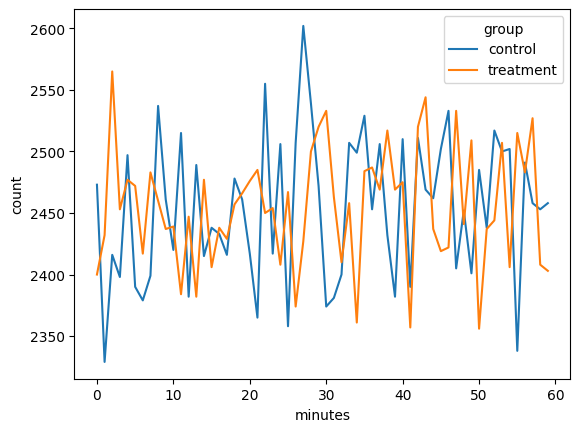

In [27]:
sns.lineplot(data=grouped, x='minutes',y='count',hue='group')
plt.show()

In [12]:
grouped = df.groupby(['minutes','group'])['converted'].mean().reset_index()

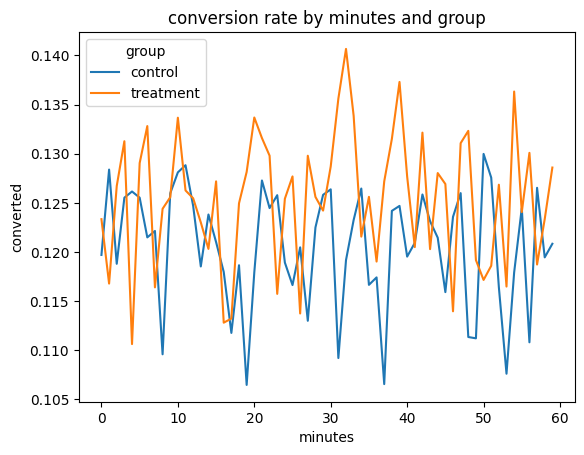

In [32]:
sns.lineplot(data=grouped, x='minutes',y='converted',hue='group')
plt.title('conversion rate by minutes and group')
plt.show()

**t_test**

In [14]:
def t_test(p1,p0,n1,n0):
    delta = p1-p0
    se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
    return delta/se

In [23]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [24]:
t_value = t_test(p1,p0,n1,n0)
t_value

np.float64(4.062826878197394)

In [27]:
from scipy.stats import t
df = min(n1,n0) -1
p_value = 2 * (1-t.cdf(abs(t_value),df))
p_value

np.float64(4.850708963211048e-05)

# t_test in stasmodels

In [37]:
from scipy.stats import ttest_ind

group_new = df[df['group'] == 'treatment']['converted']
group_old = df[df['group'] == 'control']['converted']

t_stat, p_value = ttest_ind(group_new,group_old, equal_var=False)

t_stat, p_value

(np.float64(4.062813081524187), np.float64(4.849740454611139e-05))